# Bayesian A/B Testing with Thompson Sampling

Two competing models, each yielding binary results, such as conversions vs no-conversions or likes vs dislikes

Question we'd like to answer is which model produces the largest number of conversions or likes.


In [1]:
from scipy.stats import beta
from numpy import arange, mean, random
import matplotlib.pyplot as plt

random.seed(seed=12345)

In [2]:
A_sample = 1000.
A_conversions = 600.
A_noconversions = A_sample - A_conversions

B_sample = 3.
B_conversions = 1.
B_noconversions = B_sample - B_conversions

The probability density function is defined as:

$
\begin{align}
f(x | a,b) =  \frac{\Gamma(a+b) x^{a-1} (1-x)^{b-1}}{\Gamma(a)\Gamma(b)}
\end{align}
$

where a,b > 0. In A/B tests, a is the number of convertions and b is that of no-conversions.

In [3]:
# Let's compute the number probability density functions.

# Priors
nullp = 1.  # Positive
nulln = 1.  # Negative

xstep = 0.001
x = arange(0, 1, xstep)
y_A = beta.pdf(x, a=nullp+A_conversions, b=nulln+A_noconversions)
y_B = beta.pdf(x, a=nullp+B_conversions, b=nulln+B_noconversions)

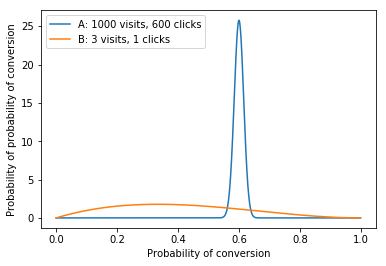

In [4]:
#plt.plot(x, beta.pdf(x, a=1, b=1), label='0 visits, 0 clicks')

labelA = 'A: %i visits, %i clicks' % (A_sample, A_conversions)
labelB = 'B: %i visits, %i clicks' % (B_sample, B_conversions)

plt.plot(x, y_A, label=labelA)
plt.plot(x, y_B, label=labelB)
plt.xlabel('Probability of conversion')
plt.ylabel('Probability of probability of conversion')
plt.legend()

In [5]:
nofsamples = 100_000

a_samples = beta.rvs(A_conversions, A_noconversions, size=nofsamples)
b_samples = beta.rvs(B_conversions, B_noconversions, size=nofsamples)

performanceAB = mean(a_samples>b_samples)*100
print('A will perform better %f %% of the times.' % performanceAB)

A will perform better 83.974000 % of the times.


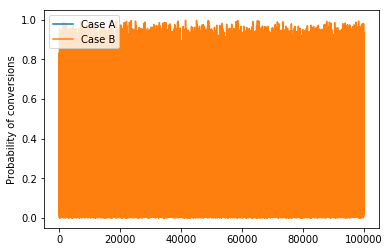

In [6]:
# Result of the simulation
plt.plot(a_samples, label='Case A')
plt.plot(b_samples, label='Case B')
plt.ylabel('Probability of conversions')
plt.legend()

In [7]:
threshold = 0.57
nofsamples = 100_000

a_samples = beta.rvs(A_conversions, A_noconversions, size=nofsamples)

valueatrisk = mean(a_samples<threshold)*100
print('There is %f %% probability that the conversion rate is lower than %f %%.' % (valueatrisk, threshold))

There is 2.752000 % probability that the conversion rate is lower than 0.570000 %.


In [ ]:
import time
import itertools
import operator
import random
import copy
import numpy
import scipy.stats
import bokeh.plotting
import bokeh.io
import bokeh.models
import bokeh.palettes


bokeh.io.output_notebook()


DISTRIBUTION_POINTS = 1001

UNIFORM = 'uniform_sampler_strategy'
BEST = 'best_option_strategy'
WORSE = 'worse_option_strategy'
THOMPSON = 'thompson_sampler_strategy'


def does_user_like(photo_id, probabilities):
    """Simulating user behavior.
    
    Parameters
    ----------
    photo_id : int
        photo id that we want to know if is liked

    probabilities : list of float
        probability of each photo of being liked

    Returns
    -------
    bool
        whether the user liked the photo or not
    """
    return random.random() < probabilities[photo_id]


def uniform_sampler_strategy(beta_params, *args):
    """Return id of a random option based on uniform sampling.
    
    Parameters
    ----------
    beta_params : list of tuple
        each item in the list is a tuple of (alpha, beta) parameters
        of the beta distribution of each option

    Returns
    -------
    int
        index of the option selected as the best

    Examples
    --------
    >>> random.seed(12345)
    >>> beta_params = [[30, 70], [50, 50]]  # both options are equally likely
    >>> uniform_sampler_strategy(beta_params)
    1
    """
    return random.choice(range(len(beta_params)))


def best_option_strategy(beta_params, probabilities):
    """Return id of the best option, checking it from the real probabilities.
    
    Parameters
    ----------
    beta_params : list of tuple
        each item in the list is a tuple of (alpha, beta) parameters
        of the beta distribution of each option

    Returns
    -------
    int
        index of the option selected as the best

    probabilities : list of float
        probability of each photo of being liked

    Examples
    --------
    >>> # best (greater) option is the third (index 2), 0.5
    >>> best_option_strategy([], (.1, .3, .5, .2))
    2
    """
    return numpy.argmax(probabilities)


def worse_option_strategy(beta_params, probabilities):
    """Return id of the worse option, checking it from the real probabilities.
    
    Parameters
    ----------
    beta_params : list of tuple
        each item in the list is a tuple of (alpha, beta) parameters
        of the beta distribution of each option

    Returns
    -------
    int
        index of the option selected as the best

    Examples
    --------
    >>> # worst (lower) option is the first (index 0), 0.1
    >>> best_option_strategy([], (.1, .3, .5, .2))
    0
    """
    return numpy.argmin(probabilities)


def thompson_sampler_strategy(beta_params, *args):
    """Return id of the expected best option to show based on Thompson sampling.
    
    Parameters
    ----------
    beta_params : list of tuple
        each item in the list is a tuple of (alpha, beta) parameters
        of the beta distribution of each option

    Returns
    -------
    int
        index of the option selected as the best

    Examples
    --------
    >>> numpy.random.seed(12345)
    >>> beta_params = [[30, 70], [50, 50]]  # second option is better, 0.5 to 0.3
    >>> thompson_sampler_select_best_option(beta_params)
    1
    """
    return numpy.argmax([scipy.stats.beta.rvs(*p) for p in beta_params])


def play_encounters(strategies, probabilities):
    """Show photos to users, and keep track on the ones liked.
    
    Parameters
    ----------
    num_votes : int
        number of times that (virtual) users will vote a photo

    strategies: list of function
        functions that implement the strategies we want to evaluate
    """

    # we initialize 4 photos, and all them with one like and one dislike
    # these are the Bayesian priors, and mean that a priori all probabilities
    # are equally likely
    status = {s.__name__: [[1, 1] for p in probabilities] for s in strategies}
    yield status

    while True:
        status = copy.deepcopy(status)
        for strategy in strategies:
            photo_to_show = strategy(status[strategy.__name__], probabilities)
            did_user_like = does_user_like(photo_to_show, probabilities)
            # updating the history with the result
            status[strategy.__name__][photo_to_show][not did_user_like] +=1

        yield status


def distributions_data(beta_params):
    data = {'x': numpy.linspace(0., 1., DISTRIBUTION_POINTS)}
    for i, params in enumerate(beta_params):
        data['y%d' % i] = scipy.stats.beta.pdf(data['x'], *params)
    return data


def distributions_plot(source, names, num_options):
    """Plot showing the beta distributions shape."""
    p = bokeh.plotting.figure(title='Probability distributions', plot_width=960, plot_height=320)

    colors = itertools.cycle(bokeh.palettes.Set1[min(max(3, num_options), 10)])

    for i, color in zip(range(num_options), colors):
        p.line('x', 'y%d' % i, color=color, legend=names[i], source=source)

    p.legend.click_policy = 'hide'

    return p


def options_data(beta_params):
    likes, dislikes = zip(*beta_params)
    num_options = len(likes)
    top = list(range(0, -num_options, -1))
    total = [l + d for l, d in beta_params]
    colors = itertools.cycle(bokeh.palettes.Set1[min(max(3, len(beta_params)), 10)])

    return {'likes': list(likes),
            'dislikes': list(dislikes),
            'total': total,
            'prob': ['%.2f' % (l / (l + d)) for l, d in beta_params],
            'color': list(itertools.islice(colors, num_options)),
            'top': top,
            'bottom': [t - .7 for t in top],
            'text_left': [t + 5 for t in total],
            'text_bottom': [t - .5 for t in top]}


def options_plot(source):
    """Plot showing the number of times each option has been samples,
    and their empiric probabilities."""
    num_options = len(source.data['likes'])
    p = bokeh.plotting.figure(title='Options', plot_width=360, plot_height=320)
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.yaxis.major_tick_line_color = None
    p.yaxis.minor_tick_line_color = None
    p.yaxis.major_label_text_font_size = '0pt'

    p.quad(left=0.1, right='dislikes', top='top', bottom='bottom', color='color', source=source, fill_alpha=.5, line_color=None)
    p.quad(left='dislikes', right='total', top='top', bottom='bottom', color='color', source=source, line_color=None)
    p.add_glyph(source, bokeh.models.glyphs.Text(x=-5, y='text_bottom', text='prob'))

    return p


def history_plot(source):
    """Plot showing the cumulative wins history of each strategy."""
    p = bokeh.plotting.figure(title='Likes history', plot_width=360, plot_height=320)
    strategies = [s for s in source.data if s != 'x']
    colors = itertools.cycle(bokeh.palettes.Plasma[min(max(3, len(strategies)), 10)])
    for strategy in strategies:
        p.line('x', strategy, legend=strategy.split('_')[0], color=next(colors), source=source)

    p.legend.location = 'top_left'
    p.legend.click_policy = 'hide'
    
    return p


def run_simulation(strategy, names, probabilities, step=1, sleep=.1):
    assert len(names) == len(probabilities)
    num_options = len(names)

    strategies = [best_option_strategy,
                  thompson_sampler_strategy,
                  uniform_sampler_strategy,
                  worse_option_strategy]

    encounters_generator = play_encounters(strategies, probabilities)
    result = next(encounters_generator)

    source_distributions = bokeh.models.sources.ColumnDataSource(data=distributions_data(result[strategy]))
    source_options = bokeh.models.sources.ColumnDataSource(options_data(result[strategy]))
    history = {s: [0] for s in result}
    history['x'] = [0]
    source_history = bokeh.models.sources.ColumnDataSource(history)

    
    joint_plot = bokeh.layouts.gridplot([[distributions_plot(source_distributions, names, num_options)],
                                         [options_plot(source_options)],
                                          [history_plot(source_history)]])

    handle = bokeh.io.show(joint_plot, notebook_handle=True)

    try:
        for i, result in enumerate(encounters_generator):
            source_distributions.stream(distributions_data(result[strategy]), DISTRIBUTION_POINTS)
            history = {s: [sum(map(operator.itemgetter(0), v))] for s, v in result.items()}
            history['x'] = [i + 1]
            source_history.stream(history)
            source_options.stream(options_data(result[strategy]), num_options)

            if not i % step:
                if sleep:
                    time.sleep(sleep)
                bokeh.io.push_notebook(handle=handle)
    except KeyboardInterrupt:
        pass

In [ ]:
probs = (0.12, 0.25)

run_simulation(strategy=THOMPSON,
               names=('%i %%' % int(probs[0]*100), '%i %%' % int(probs[1]*100)),
               probabilities=probs)